# Preprocessing data

## Import relevant libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Data/train_churn.csv')

# 1. Outliers detection

In [4]:
cat_columns = []
num_columns = []

cat_columns = df.select_dtypes(include=['object']).columns
cat_columns = cat_columns.drop('state')
num_columns = df.select_dtypes(include=['number']).columns
num_columns = num_columns.drop(['account_length', 'number_customer_service_calls'])

In [5]:
df_num = df[num_columns]
df_num.describe()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

number_vmail_messages    True
total_day_minutes        True
total_day_calls          True
total_day_charge         True
total_eve_minutes        True
total_eve_calls          True
total_eve_charge         True
total_night_minutes      True
total_night_calls        True
total_night_charge       True
total_intl_minutes       True
total_intl_calls         True
total_intl_charge        True
dtype: bool

## 1.1 Outliers visualization

In [6]:
colors = sns.color_palette(palette='hls',
                           n_colors=len(num_columns))

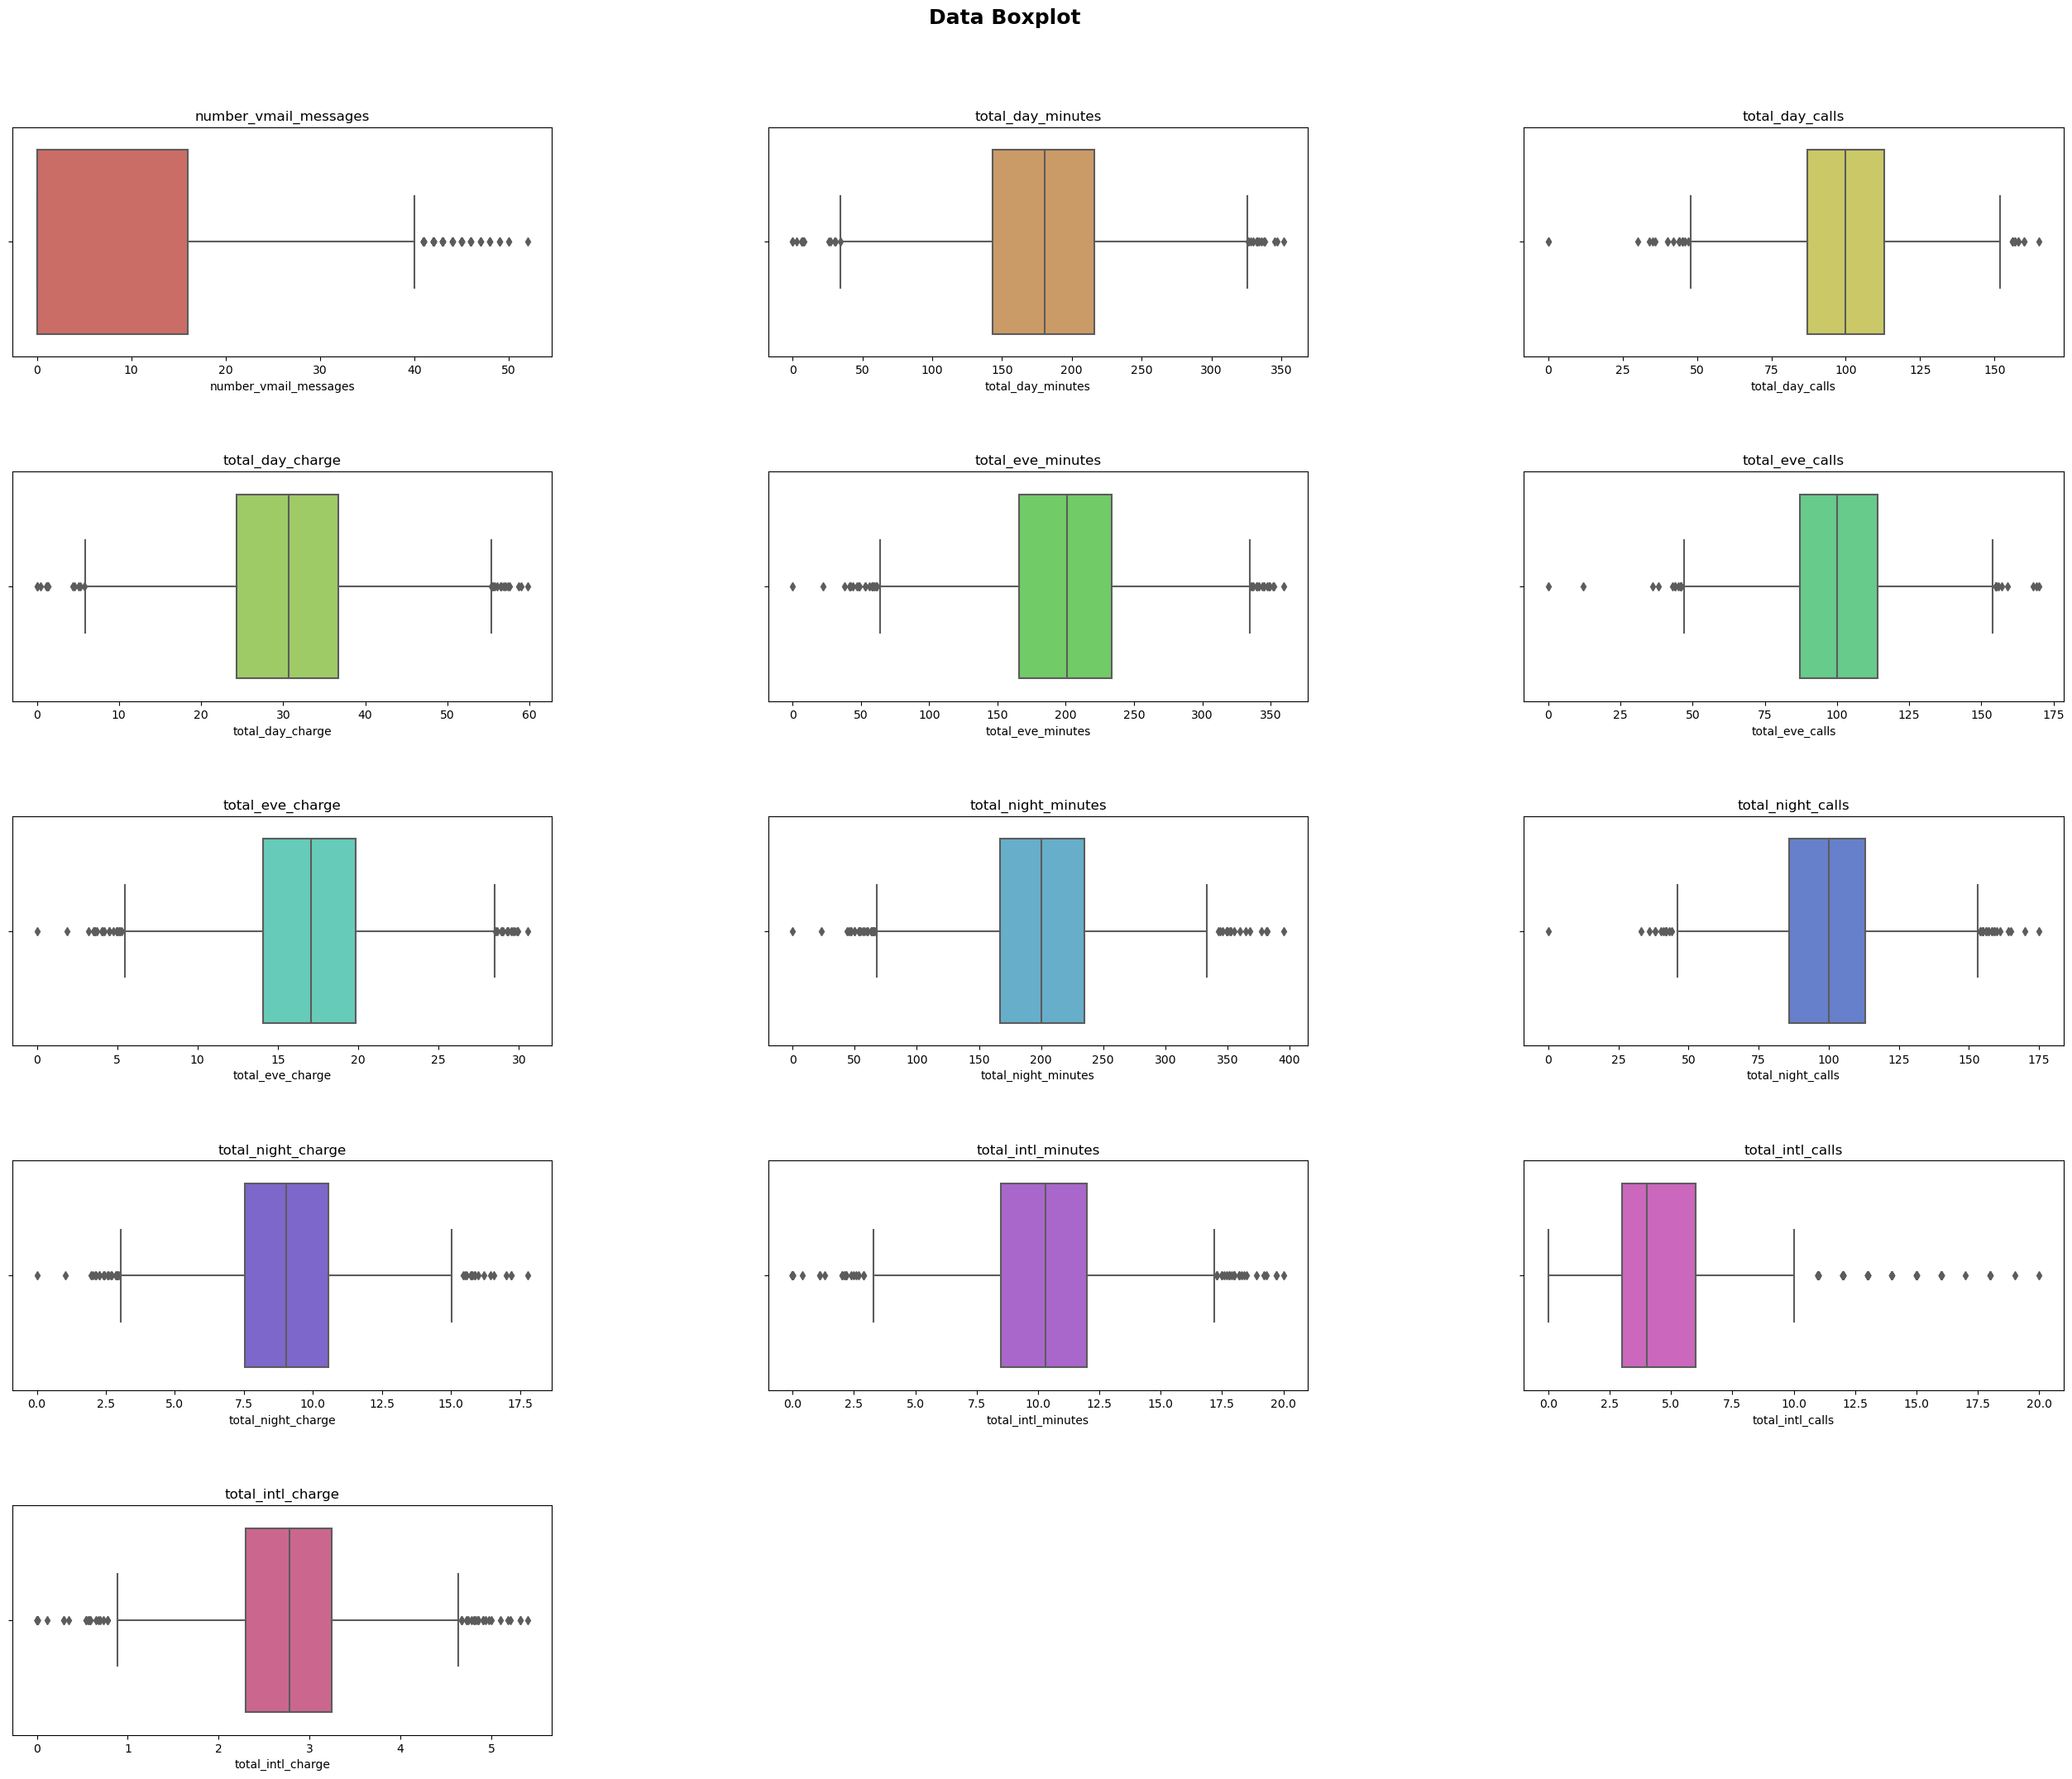

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(32, 24))
fig.suptitle('Data Boxplot', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)

# Iterate over numerical columns
for i, col in enumerate(num_columns):
    ax = axes.flatten()[i]
    
    # Plot boxplot
    sns.boxplot(data=df, x=col, color=colors[i], ax=ax)
    
    # Set title and x-axis label
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')

for i in range(1,3):
    plt.delaxes(axes.flatten()[-i])
    
plt.show()

## 1.2 Finding IQR

In [8]:
dict = {}
for col in num_columns:
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    IQR  = percentile75 - percentile25 
    upper_limit = percentile75 + 1.5 * IQR 
    lower_limit = percentile25 - 1.5 * IQR
    dict['upper_limit'+ '_' + col] = upper_limit
    dict['lower_limit'+ '_' + col] = lower_limit 

In [9]:
for col in num_columns:
    print('There are total {} Customers data which {} are less than lower limit.'.format(len(df[df[col] < dict['lower_limit_' + col]] ) , col))
    print('There are total {} Customers data which {} are more than upper limit.'.format(len(df[df[col] > dict['upper_limit_' + col]] ) , col))



There are total 0 Customers data which number_vmail_messages are less than lower limit.
There are total 86 Customers data which number_vmail_messages are more than upper limit.
There are total 12 Customers data which total_day_minutes are less than lower limit.
There are total 13 Customers data which total_day_minutes are more than upper limit.
There are total 18 Customers data which total_day_calls are less than lower limit.
There are total 10 Customers data which total_day_calls are more than upper limit.
There are total 12 Customers data which total_day_charge are less than lower limit.
There are total 14 Customers data which total_day_charge are more than upper limit.
There are total 19 Customers data which total_eve_minutes are less than lower limit.
There are total 15 Customers data which total_eve_minutes are more than upper limit.
There are total 13 Customers data which total_eve_calls are less than lower limit.
There are total 11 Customers data which total_eve_calls are more t

Now, we are going to handle the outliers:

In [10]:
for col in num_columns:
    df[col] = np.where(
        df[col] > dict['upper_limit_' + col],
        dict['upper_limit_' + col],
        np.where(
            df[col] < dict['lower_limit_' + col],
            dict['lower_limit_' + col],
            df[col]  
        )
    )

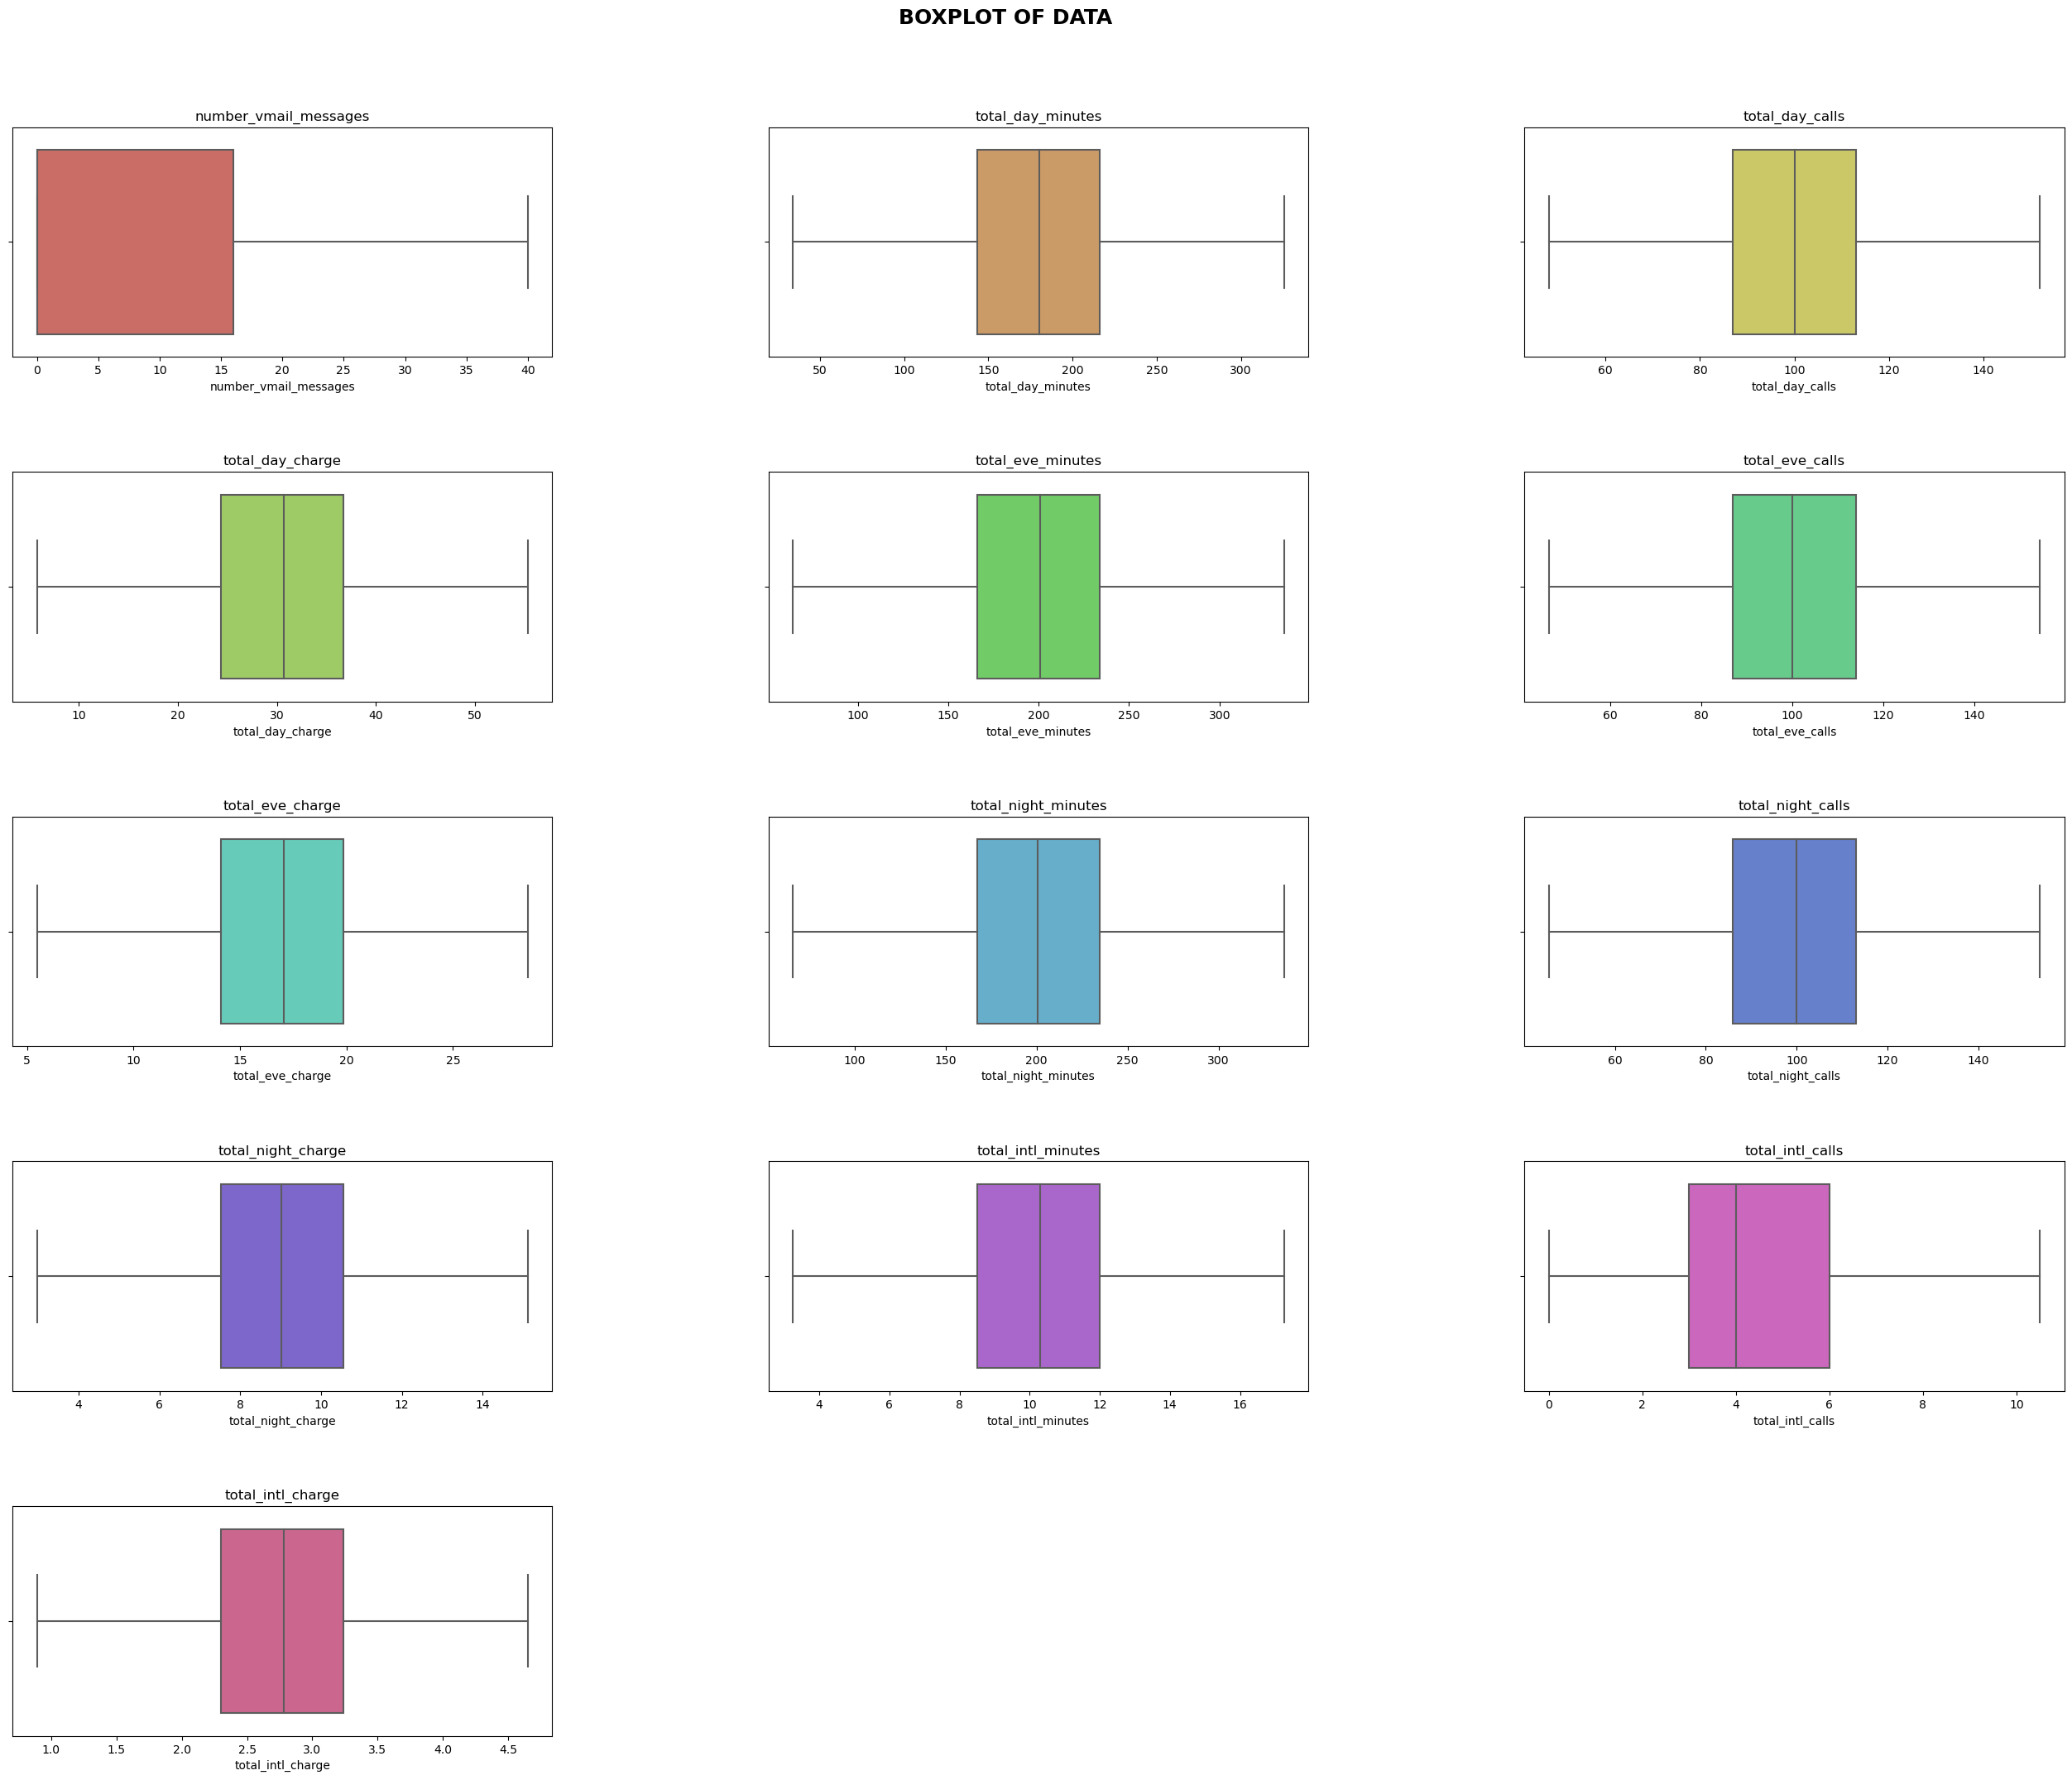

In [11]:
fig, axes = plt.subplots(5, 3, figsize=(32, 24))
fig.suptitle('BOXPLOT OF DATA', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.4)

# Iterate over numerical columns
for i, col in enumerate(num_columns):
    ax = axes.flatten()[i]
    
    # Plot boxplot
    sns.boxplot(data=df, x=col, color=colors[i], ax=ax)
    
    # Set title and x-axis label
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')

for i in range(1,3):
    plt.delaxes(axes.flatten()[-i])

plt.show()

# 2. Features Engineering

## 2.1 Numerical columns

In [12]:
df['total_net_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
df['total_net_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']
df['total_net_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

df.drop(columns= ['state', 'area_code'],
        inplace= True)

In [13]:
df.drop(columns=['total_day_charge', 'total_eve_charge','total_night_charge',
                'total_day_calls','total_eve_calls', 'total_night_calls', 'total_day_minutes', 
                 'total_eve_minutes', 'total_night_minutes'],
        inplace=True)

## 2.2 Categorical columns

In [14]:
df['voice_mail_plan'] = df['voice_mail_plan'].map({'yes': 1,
                                                   'no': 0}) 
df['international_plan'] = df['international_plan'].map({'yes': 1,
                                                         'no': 0}) 
df['churn'] = df['churn'].map({'yes': 1,
                               'no': 0}) 

- We've calculated new columns to represent total net usage metrics. For each entry in the dataset, we added up the minutes, calls, and charges for day, evening, and night periods. This gives us comprehensive metrics for overall usage: 'total_net_minutes', 'total_net_calls', and 'total_net_charge'.
- Certain features in our data are categorical, such as 'voice_mail_plan', 'international_plan', and 'churn' (indicating whether a customer churned or not). To make them compatible with machine learning algorithms, we've converted them to numeric values:

   - 'voice_mail_plan' now has 1 for 'yes' and 0 for 'no'.
   - 'international_plan' is encoded as 1 for 'yes' and 0 for 'no'.
   - 'churn' is represented as 1 for 'yes' and 0 for 'no'.
- We've removed some columns, specifically 'state' and 'area_code', to streamline the dataset and focus on the most relevant features for our analysis.

In [15]:
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_net_minutes,total_net_calls,total_net_charge
0,107,0,1,26.0,13.7,3.0,3.70,1,0,611.50,329.0,55.540
1,137,0,0,0.0,12.2,5.0,3.29,0,0,527.20,328.0,59.000
2,84,1,0,0.0,6.6,7.0,1.78,2,0,560.45,248.0,65.215
3,75,1,0,0.0,10.1,3.0,2.73,3,0,501.90,356.0,49.360
4,121,0,1,24.0,7.5,7.0,2.03,3,0,766.35,314.0,75.175


### Correlation Analysis

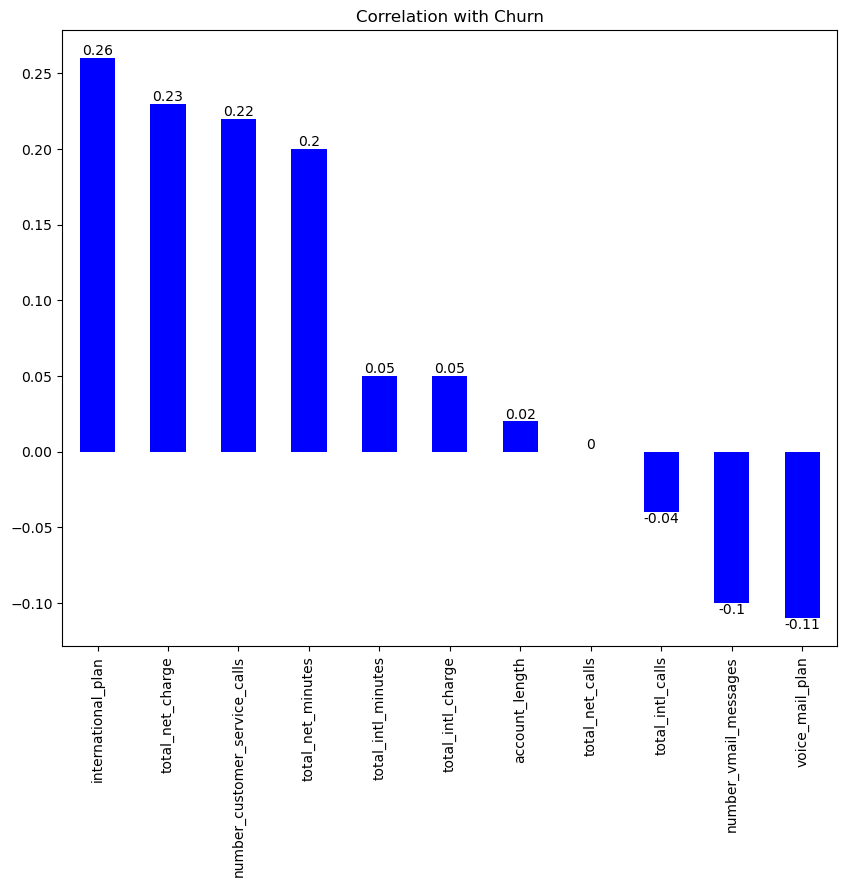

In [16]:
correlation_series = round(df.corr()['churn'].sort_values(ascending=False)[1:], 2)


ax = correlation_series.plot(kind='bar',
                             color='blue',
                             figsize=(10, 8))
ax.bar_label(ax.containers[0])

# Set plot title
plt.title('Correlation with Churn')
plt.show()

### Heatmap

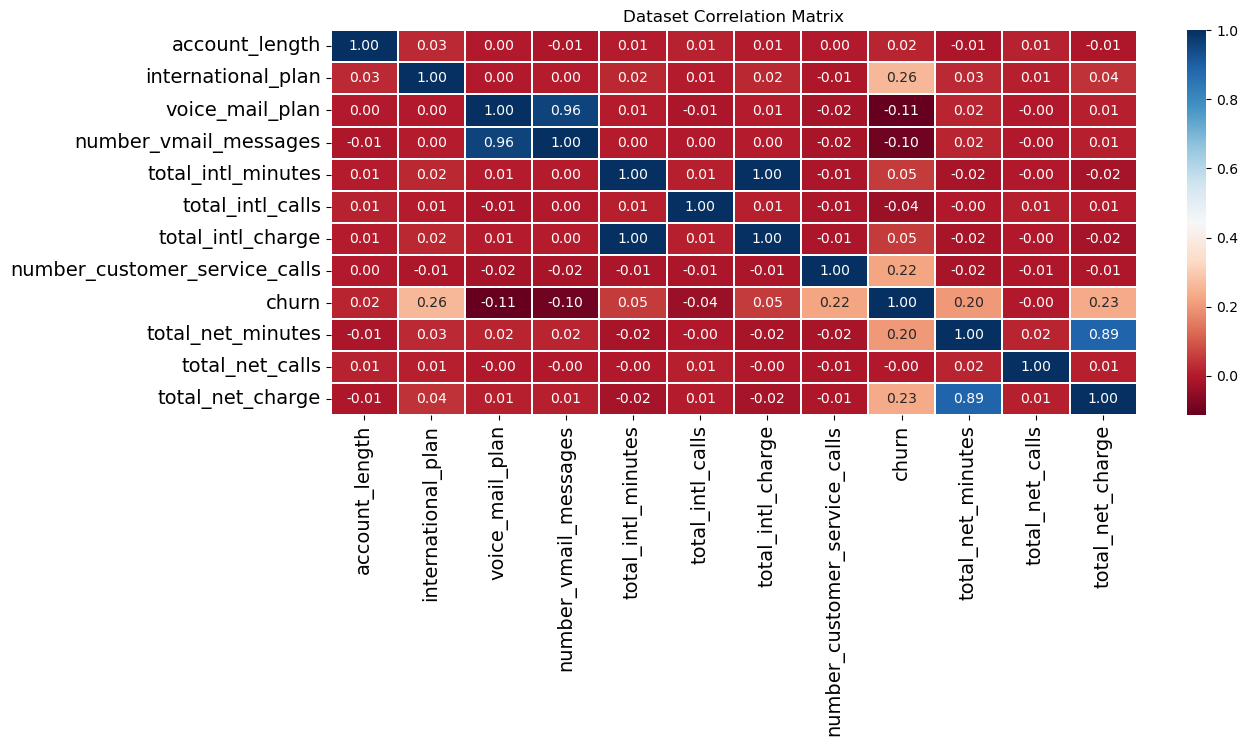

In [17]:
fig, ax = plt.subplots(figsize=[13,5])

sns.heatmap(df.corr(),
            ax=ax,
            annot=True,
            linewidths=0.05,
            fmt= '.2f',
            cmap='RdBu')

ax.tick_params(axis='both',
               which='major',
               labelsize=14)

ax.set_title('Dataset Correlation Matrix')
fig.show()

# 3. Save the preprocessed data

In [18]:
path = 'Data/preprocessed_train_churn.csv'
df.to_csv(path,
          index=False)